# University of Aberdeen

## Applied AI (CS5079)

### Assessment 1 Task 2 - Reinforcement Learning from the RAM

---


## Imports

In [ ]:
# openai has preprocessing modules in their baselines repository such as FrameStack, NoopResetEnv, episode_life, etc.
!pip install git+https://github.com/openai/baselines.git

In [2]:
# Seed value used for achieving reproducibility
SEED_VALUE = 1337

# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
# For handling files
import os
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['TF_CUDNN_DETERMINISM'] = '1'
os.environ['PYTHONHASHSEED'] = str(SEED_VALUE)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
import random
random.seed(SEED_VALUE)

# 3. Set the `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(SEED_VALUE)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.random.set_seed(SEED_VALUE)

# https://github.com/openai/baselines
from baselines.common.atari_wrappers import FrameStack

# For plotting graphs
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# OpenAI Gym
import gym
FRAME_STACK_SIZE = 5
env = gym.make("Asterix-ram-v0")
# Stack the ram inputs by FRAME_STACK_SIZE * env.unwrapped._get_ram().shape
env = FrameStack(env, FRAME_STACK_SIZE)

# Seed the Atari game environment
# for reproducibility purposes
env.seed(SEED_VALUE)

[1337, 17452119]

## Task 2.1

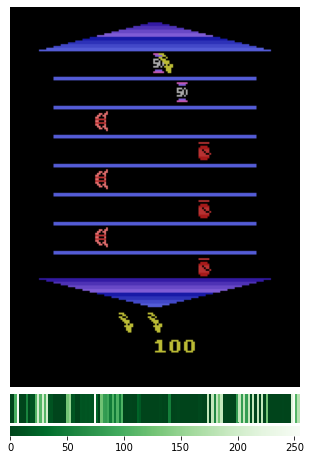

In [190]:
import seaborn as sns
import pandas as pd

# Plot the Atari game image against its
# corresponding RAM state input to highlight
# The 128 vertical bars at the bottom of the image
# represent the RAM state of the memory, 
# with black representing 0 and lighter color corresponding
# to higher values of a given memory cell.
env.reset()
for i in range(60):
    env.step(i%9)
grid_kws = {"height_ratios": (10, .75, .25)}
f, (img_ax, ram_ax, cbar_ax) = plt.subplots(3, gridspec_kw=grid_kws, figsize=(7, 10))
img_ax.imshow(env.unwrapped._get_image())
img_ax.axis('off')
img_ax.set_aspect('equal')
sns.heatmap(np.atleast_2d(env.unwrapped._get_ram()), cbar=True, yticklabels=False, xticklabels=False, cmap='Greens_r',
            ax=ram_ax, cbar_ax=cbar_ax, cbar_kws={"orientation": "horizontal"})
plt.subplots_adjust(left=0.125,
                    bottom=0.2, 
                    right=.7, 
                    top=0.8, 
                    wspace=0, 
                    hspace=0.025)
plt.show()

In [141]:
def normalise(ram, scale=255):
    """Normalise the RAM state inputs (b/w 0 and 1).
    """
    return ram/scale

In [142]:
obs = env.reset()

In [143]:
normalise(np.array(obs))

array([0.        , 0.        , 0.39215686, 0.98431373, 0.        ,
       0.        , 0.        , 0.26666667, 0.00392157, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.04705882, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 1.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

For a more detailed explanation please refer to the report

## Task 2.2

For architecture, refer to report appendix.

In [3]:
# Import the garbage collector package
import gc

def reset_random_seeds():
    """Reset the random number generator seed to achieve full reproducibility 
    even when running the script on GPU
    """
    
    # Set the environment determinism to guarantee
    # reproducibility of the results
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISM'] = '1'
    os.environ['PYTHONHASHSEED']=str(SEED_VALUE)
    tf.random.set_seed(SEED_VALUE)
    np.random.seed(SEED_VALUE)
    random.seed(SEED_VALUE)
    
    # Perform garbage collection
    gc.collect()
    print("Random number generator seed reset!")  # optional

### Defining global variable and importing packages for training the models

In [4]:
# Import the Keras layer used for building our models
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import HeUniform

INPUT_SHAPE = env.observation_space.shape
NUM_ACTIONS = env.action_space.n
BATCH_SIZE = 32
MEMORY_SIZE = 25000
EXPLORATION_STEPS = 20000
LEARNING_RATE = 0.00025

In [5]:
class SumTree:
    """Code is adapted from an open-source MIT-licensed GitHub repository.
    It implements an optimisation experience replay memory technique that can
    be used for all Atari games DQNs. 
    
    Source: https://github.com/rlcode/per
    Args:
        capacity (int): size of the sum tree
    """
    # The data pointer class variable
    write = 0

    def __init__(self, capacity):
        """Initialize the tree with all nodes and data with values set to 0.
        """
        # Number of leaf nodes (final nodes) that contains experiences
        self.capacity = capacity
        
        # Generate the tree with all nodes values = 0
        # To understand this calculation (2 * capacity - 1) look at the schema above
        # Remember we are in a binary node (each node has max 2 children) so 2x size of leaf (capacity) - 1 (root node)
        # Parent nodes = capacity - 1
        # Leaf nodes = capacity
        self.tree = np.zeros(2 * capacity - 1)
        
        # Store the experiences (so the size of data is capacity)
        self.data = np.zeros(capacity, dtype=object)

    def _propagate(self, idx, change):
        """Recursively propagate a given child node change through the sum tree.
        """
        
        # Get the parent node index
        parent = (idx - 1) // 2
        
        # Apply the child node change to the parent node
        self.tree[parent] += change
        
        # Do this until the root node is reached
        if parent != 0:
            self._propagate(parent, change)

    def _retrieve(self, idx, s):
        """Return a leaf node (priority) index for the current experience (observation)
        """
        left = 2 * idx + 1
        right = left + 1

        if left >= len(self.tree):
            return idx

        if s <= self.tree[left]:
            return self._retrieve(left, s)
        else:
            return self._retrieve(right, s - self.tree[left])

    def total(self):
        """Return the root node (total sum of the experience priority values).
        """
        return self.tree[0]

    def add(self, p, data):
        """Add the experience and its priority score (as a leaf) to the sum tree.
        """
        # Get the tree index for the experience (observation)
        idx = self.write + self.capacity - 1
        
        # Update the sum tree data
        self.data[self.write] = data
        
        # Update the sum tree probability values
        self.update(idx, p)
        
        # Increment the data pointer
        self.write += 1
        
        # If over the capacity, go back to first index (we overwrite)
        if self.write >= self.capacity:
            self.write = 0

    def update(self, idx, p):
        """Update the leaf priority score and propagate the change through tree.
        """
        # Change = new priority score - former priority score
        change = p - self.tree[idx]
        self.tree[idx] = p
        
        # Propagate the change through tree
        self._propagate(idx, change)

    def get(self, s):
        """Return the leaf index, priority value and its associated experience (observation).
        """
        # Get the leaf index
        idx = self._retrieve(0, s)
        
        # Get the experience (observation) index
        dataIdx = idx - self.capacity + 1

        return (idx, self.tree[idx], self.data[dataIdx])
    

#-------------------- MEMORY --------------------------
class Memory:
    """Code is adapted from an open-source MIT-licensed GitHub repository.
    It implements an optimisation experience replay memory technique that can
    be used for all Atari games DQNs. 
    
    Source: https://github.com/rlcode/per
    
    Args:
        capacity (int): size of the sum tree
    """
    # Hyperparameter to avoid assigning 0 probability to experiences
    e = 0.01
    
    # Hyperparameter to make a trade-off between random sampling and taking a
    # a high priority experience (observation)
    a = 0.6

    def __init__(self, capacity):
        """Initialise the sum tree with the given capacity.
        """
        self.tree = SumTree(capacity)

    def _getPriority(self, error):
        return (error + self.e) ** self.a

    def add(self, error, sample):
        """Store a new experience in the tree along with its corresponding priority value.
        """
        # Get the priority from the experience (observation) error
        p = self._getPriority(error)
        
        # Store the priority and the experience (observation)
        self.tree.add(p, sample) 

    def sample(self, n):
        """Sample a n-sized batch of priority index and observation pair.
        """
        # Create a list to hold the batch pairs
        batch = []
        
        # Calculate and store the priority segment
        segment = self.tree.total() / n
        
        # Populate the batch list
        for i in range(n):
            a = segment * i
            b = segment * (i + 1)

            s = random.uniform(a, b)
            (idx, p, data) = self.tree.get(s)
            batch.append( (idx, data) )

        return batch

    def update(self, idx, error):
        """Update the sum tree leaves (priorities).
        """
        # Get the priority from the experience (observation) error
        p = self._getPriority(error)
        
        # Update the sum tree probability values
        self.tree.update(idx, p)

In [6]:
from collections import deque
import math

MAX_EPSILON = 1
MIN_EPSILON = 0.1
LAMBDA = - math.log(0.01) / EXPLORATION_STEPS  # speed of decay

class DDQNAgent():
    """Code is adapted from an open-source MIT-licensed GitHub repository.
    It implements an DDQ Network and Agent experience replay memory technique that can
    be used for all Atari games DQNs. 
    
    Source: https://github.com/jaromiru/AI-blog
    
    Args:
        lr (float): learning rate of the network
    """
    steps = 0
    
    def __init__(self, lr=LEARNING_RATE):
        """Initialise the agent and the online and target DDQNs for the environment.
        """
        # The DDQN agent learning rate attribute
        # used for the Adam optimiser when building 
        # our model architecture.
        self.lr = lr
        
        # DDQN agent memory represented by a SumTree class instance
        # (faster batch sampling, thus, better runtime performance)
        self.memory = Memory(MEMORY_SIZE)
        
        # Set the initial DDQN models loss value to be +inf
        self.loss_val = np.inf
        self.action_size = NUM_ACTIONS
        
        # Disable eager execution which boosts runtime
        # Eager execution is generally used for debugging purposes
        tf.compat.v1.disable_eager_execution()
        self.discount_rate = 0.99

        # Create the two networks for predicting the actions
        
        # The first model makes the predictions for Q-values 
        # which are used to make a action.
        self.online = self.q_network(layers=4)
        
        # Build a target model for the prediction of future
        # rewards. The weights of a target model get updated 
        # every 10,000 steps thus when the loss between the 
        # Q-values is calculated the target Q-value is stable.
        self.target = self.q_network(layers=4)

        #The "target" DNN will take the values of the "online" DNN
        self.update_target()


    def q_network(self, layers=2):
        """Define and return the CNN model architecture.
        """
        # Ensure reproducibility of the results
        # by resetting the random seeds
        reset_random_seeds()

        # Build the model
        kernel_init = HeUniform()
        model = Sequential()

        model.add(Dense(128, activation='relu', input_shape=INPUT_SHAPE, kernel_initializer=kernel_init))
        for num_layers in range(layers-1):
            model.add(Dense(128, activation='relu', kernel_initializer=kernel_init))
        model.add(Dense(NUM_ACTIONS, activation="linear", kernel_initializer=kernel_init))
        
        # In the Deepmind paper they use RMSProp however then Adam optimizer
        # improves training time
        model.compile(loss="huber_loss", optimizer=Adam(learning_rate=self.lr))
        return model
            
    def update_target(self):
        """Update the target network with the online network weights.
        """
        # Get the online DQN weights
        online_weights = self.online.get_weights()
        
        # Update the target DQN weights
        self.target.set_weights(online_weights)
        
    #---- CHOSSING ACTION ----
    def get_action(self, state, step):
        """Based on the Epsilon agent chooses wheter to explore or exploatate
        """
        if step <= EXPLORATION_STEPS:
            return np.random.randint(self.action_size)
        else:     
            self.steps += 1
            epsilon = MIN_EPSILON + (MAX_EPSILON - MIN_EPSILON) * math.exp(-LAMBDA * self.steps)
            if np.random.rand() < epsilon:
                return np.random.randint(self.action_size)# random action
            else:
                q_values = self.online.predict(state.reshape(-1, *INPUT_SHAPE))
                return np.argmax(q_values) # optimal action
    
    def get_train_data(self, batch):
        """Decide on the input, desired output and error of the current state.
        """
        no_state = np.zeros(INPUT_SHAPE)
        
        prev_states = np.array([obs[1][0] for obs in batch])
        
        # No state if done = True
        next_states = np.array([(no_state if obs[1][4] is True else obs[1][3]) for obs in batch])
        
        # Make predictions based on the previous states
        # using the online model
        prev_q_vals = self.online.predict(prev_states)
        
        # Make predictions based on the next states
        # using the online model (used in the function for 
        # calculating the future q values of the DDQN)
        next_q_vals_double = self.online.predict(next_states)
        
        # Make predictions based on the next states
        # using the target model
        next_q_vals = self.target.predict(next_states)
        
        # Create NumPy arrays for storing the previous states and future q values,
        # and the calculated error values (used for determining state priorities)
        # respectively
        X = np.zeros((len(batch), *INPUT_SHAPE))
        Y = np.zeros((len(batch), NUM_ACTIONS))
        errors = np.zeros(len(batch))
        
        for idx in range(len(batch)):
            
            # Unpack the current batch sample
            curr_state, action, reward, next_state, done = batch[idx][1]
            
            q_val = prev_q_vals[idx]
            prev_q_val = q_val[action]
            
            # Future q value
            future_q_val = q_val
            
            if done:
                future_q_val[action] = reward
            else:
                future_q_val[action] = reward + next_q_vals[idx][np.argmax(next_q_vals_double[idx])] * self.discount_rate
            
            # Populate the previous state and future q value lists 
            X[idx] = curr_state
            Y[idx] = future_q_val
            
            # Calculate the error values for each experience (observation)
            errors[idx] = abs(prev_q_val - future_q_val[action])
        return (X, Y, errors)
    
    def save_to_memory(self, curr_state, action, reward, next_state, done, step):
        """Update the sum tree priorities and observations (samples).
        """
        sample = (curr_state, action, reward, next_state, done)
        if step <= EXPLORATION_STEPS:
            error = abs(sample[2])  # Reward
            self.memory.add(error, sample)
        else:
            X, Y, errors = self.get_train_data([(0, sample)])
            self.memory.add(errors[0], sample)
        
    def train(self, step):
        """Train the online model and update the loss value.
        """
        # Sample a batch error-observation pairs
        batch = self.memory.sample(BATCH_SIZE)
        X, Y, errors = self.get_train_data(batch)
        
        # Update errors
        for i in range(len(batch)):
            idx = batch[i][0]
            self.memory.update(idx, errors[i])
        
        # Fit the online DDQN and update the loss value
        hist = self.online.fit(X, Y, batch_size=BATCH_SIZE, epochs=1, verbose=0, shuffle=True)
        self.loss_val = hist.history['loss'][0]
    


Please refer to the report for further information regarding the deployment and parameter adjustments of the agent.

## Task 2.3

In [ ]:
import time

# Initialise the DDQN agent 
agent = DDQNAgent()  

# Lists to hold the steps and their corresponding rewards respectively 
ep_steps, ep_rewards = [], []

# To hold the total episode reward of the agent
total_reward = 0

# Total number of training steps
N_STEPS = 1000000 

# Train the model after 4 actions
TRAIN_ONLINE_STEPS = 4

# Update teh target every 10,000 steps (1 epoch)
# Considered as a hyperparameter
UPDATE_TARGET_STEPS = 10000

# Reset the environment seed (for reproducibility)
env.seed(SEED_VALUE)
done=True
for step in range(N_STEPS):
    
    # Calculate the DDQN agent training process
    # completion as percentage
    total_perc = step * 100 / N_STEPS
    
    # Print the current step, total number of training steps, training process percentage and DDQN loss value
    print(f"\r\tAction step: {step}/{N_STEPS} ({total_perc:.2f}%)\tLoss: {agent.loss_val:5f}", end="")
    
    # Reset the game environment once the ddqn_agent
    # is out of lives
    if done: 
        
        # Calculate the average reward for the episode (for 3 lives)
        avg_reward = int(total_reward/3)
        
        # Append the total reward and episode steps
        # used later for plotting and printing
        if step:
            ep_rewards.append(total_reward)
            ep_steps.append(step)
        print(f"\tAVG reward: {avg_reward}\tTotal mean: {np.mean(ep_rewards)}")
        
        # Reset the game environment and get the initial observation
        obs = env.reset()
        
        # Convert the observation to NumPy array
        # since we need such an array to carry out the ddqn_agent training
        state = normalise(np.array(obs))
        total_reward = 0


    # Get a exploration/exploitation action
    action = agent.get_action(state, step)

    # Take a step in the game environment
    next_state, reward, done, info = env.step(action)
    
    # Convert to NumPy array and normalise
    next_state = normalise(np.array(next_state))
    
    # Update the sum tree priorities and observations (samples)
    agent.save_to_memory(state, action, reward, next_state, done, step)
    
    # Skip training the agent if still exploring
    if step > EXPLORATION_STEPS:
        
        # Train the online DDQN every 4th frame
        if step % TRAIN_ONLINE_STEPS == 0:
            agent.train(step)

        # Regularly copy the online DDQN to the target DDQN
        if step % UPDATE_TARGET_STEPS == 0:
            agent.update_target()
    
#     env.render()
    total_reward += reward
    state = next_state
env.close()

## Plotting

In [12]:
import pandas as pd
# train_df = pd.read_csv('ddqn_data.csv')
# train_df.iloc[:, 1:]
# Create data frame for the obtained training data
train_df = pd.DataFrame(data={'Step': ep_steps, 'Reward': ep_rewards})

# Calculate cumulative mean of the rewards
train_df['Total Mean'] = train_df['Reward'].expanding().mean()

# Calculate cumulative sum of the rewards
train_df['Total Reward'] = train_df['Reward'].cumsum()
train_df.head(n=5)

,Step,Reward,Total Mean,Total Reward
0,543,550.0,550.0,550.0
1,927,400.0,475.0,950.0
2,1315,250.0,400.0,1200.0
3,1630,200.0,350.0,1400.0
4,1996,350.0,350.0,1750.0


### Functions

In [1]:
# Function for plotting the DDQN training data
def plot_df(df, cols, x_label, y_label, title, title_fontsize=20, label_fontsize=16):
    plt.rcParams['figure.figsize']= (20, 6)
    for col in cols:
        df[col].plot(fontsize=12)
    plt.legend(loc=2, prop={'size': 14})
    plt.xlabel(x_label, fontsize=label_fontsize)
    plt.ylabel(y_label, fontsize=label_fontsize)
    plt.title(title, fontsize=title_fontsize)
    plt.show()

In [2]:
def plot_boxplot_for_episodes(df, cols, models, x_label, y_label, title, title_fontsize=30, label_fontsize=20):
    fig, ax = plt.subplots(figsize=(25, 10))

    plt.xlabel(x_label, fontsize=label_fontsize)
    plt.ylabel(y_label, fontsize=label_fontsize)
    plt.title(title, fontsize=title_fontsize)
    step = 50000
    dfs = {}
    for episode in range(0, 1000000, step):
        cur_episode_df = df[(df['Step']<= episode + step) & (df['Step']>episode)][cols]
        dfs[(episode/step) + 1] = cur_episode_df.values.reshape(-1)

    medianprops = dict(linestyle='-.', linewidth=2.5, color='firebrick')
    meanpointprops = dict(marker='D', markeredgecolor='black', markerfacecolor='firebrick')
    plt.boxplot(dfs.values(), showmeans=True, medianprops=medianprops, meanprops=meanpointprops)

    plt.yticks(fontsize=20)
    ax.set_xticklabels(dfs.keys(), fontsize=label_fontsize)
    plt.show()

In [3]:
def plot_violinplot_for_episodes(df, cols, models, x_label, y_label, title, title_fontsize=30, label_fontsize=20):
    fig, ax = plt.subplots(figsize=(25, 10))

    plt.xlabel(x_label, fontsize=label_fontsize)
    plt.ylabel(y_label, fontsize=label_fontsize)
    plt.title(title, fontsize=title_fontsize)
    step = 50000
    dfs = {}
    quantiles= []
    for episode in range(0, 1000000, step):
        cur_episode_df = df[(df['Step']<= episode + step) & (df['Step']>episode)][cols]
        dfs[(episode/step) + 1] = cur_episode_df.values.reshape(-1)
        quantiles.append([0.25, 0.5, 0.75])
   
    plt.violinplot(dfs.values(), quantiles=quantiles)

    plt.yticks(fontsize=20)
    plt.xticks(ticks=[i for i in range(1, len(dfs.keys())+1)], labels=dfs.keys(), fontsize=label_fontsize)
    plt.show()

### Plots

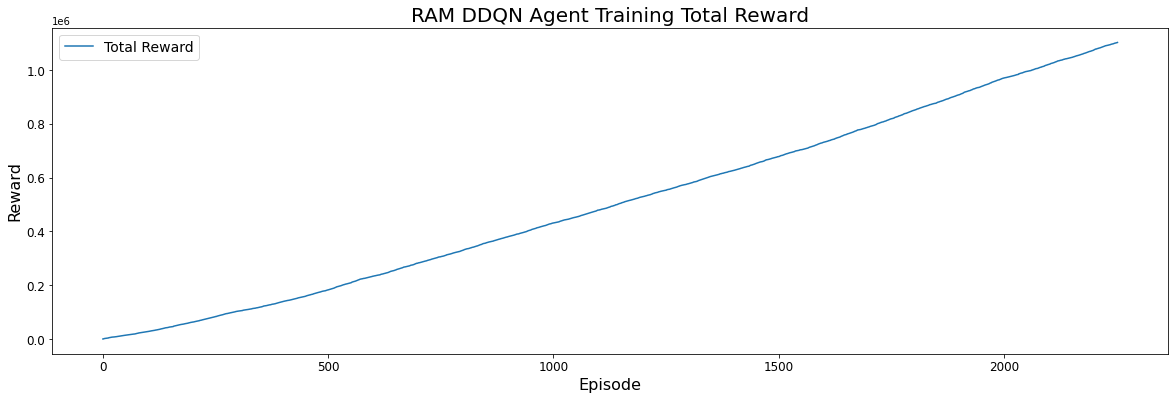

In [5]:
# Plot the training reward cumulative sum throughout the episodes (1 episode = 3 player lives)
plot_df(train_df, 
        cols=['Total Reward'], 
        x_label='Episode', 
        y_label='Reward', 
        title='RAM DDQN Agent Training Total Reward')

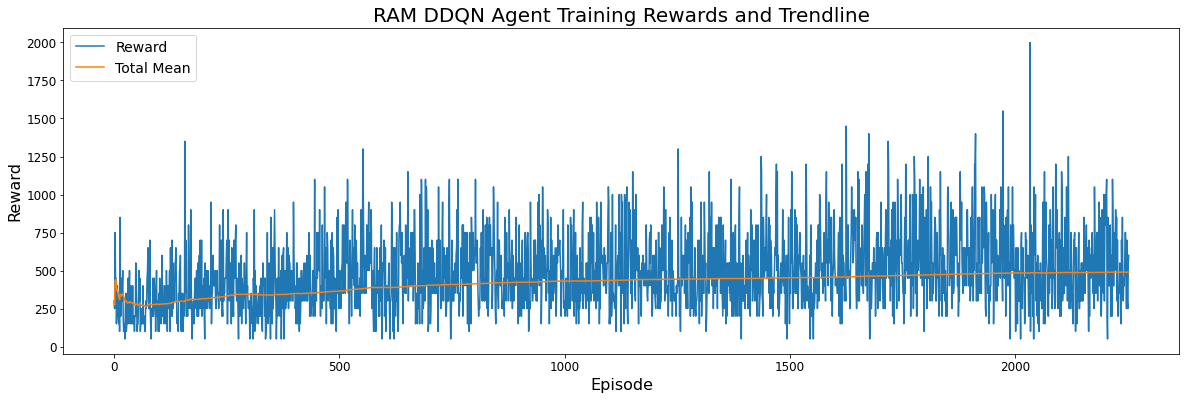

In [6]:
# Plot the training reward values throughout the episodes (1 episode = 3 player lives)
plot_df(train_df, 
        cols=['Reward', 'Total Mean'], 
        x_label='Episode', 
        y_label='Reward', 
        title='RAM DDQN Agent Training Rewards and Trendline')

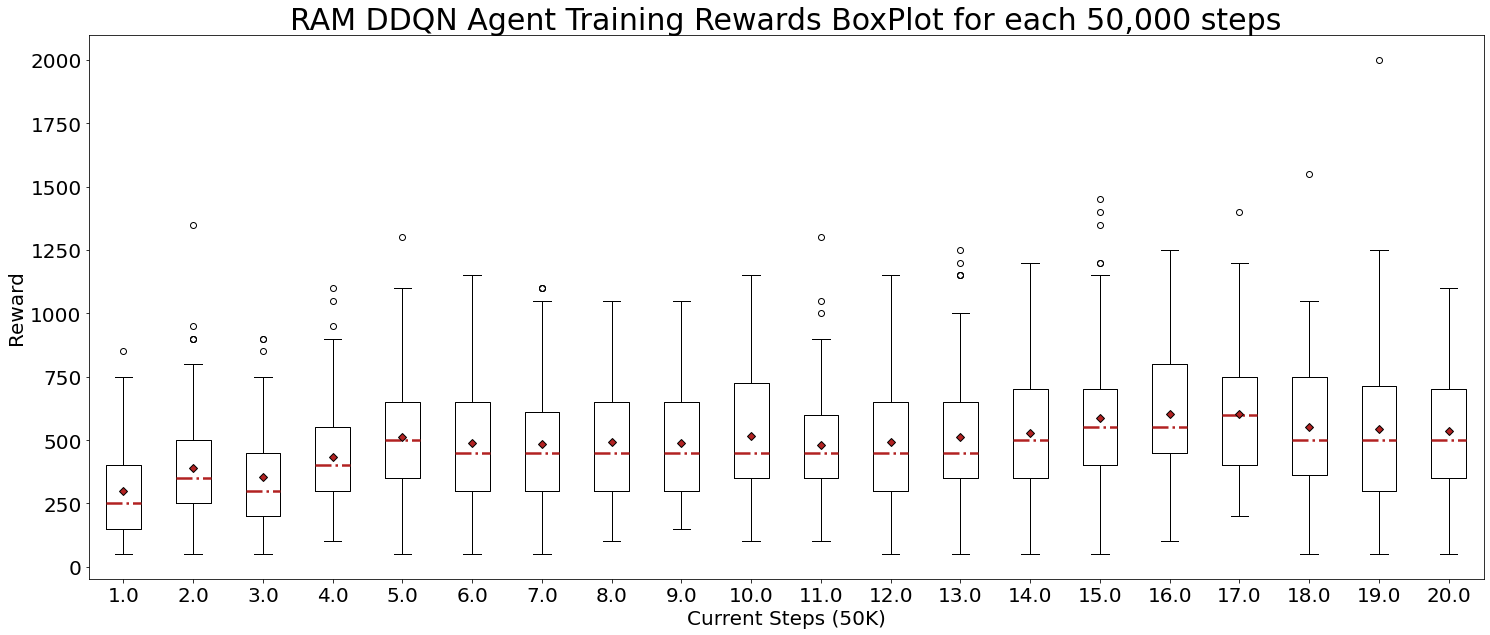

In [7]:
plot_boxplot_for_episodes(train_df, 
                          ['Reward'], 
                          ['DDQN-Image'], 
                          x_label='Current Steps (50K)', 
                          y_label='Reward', 
                          title='RAM DDQN Agent Training Rewards BoxPlot for each 50,000 steps')

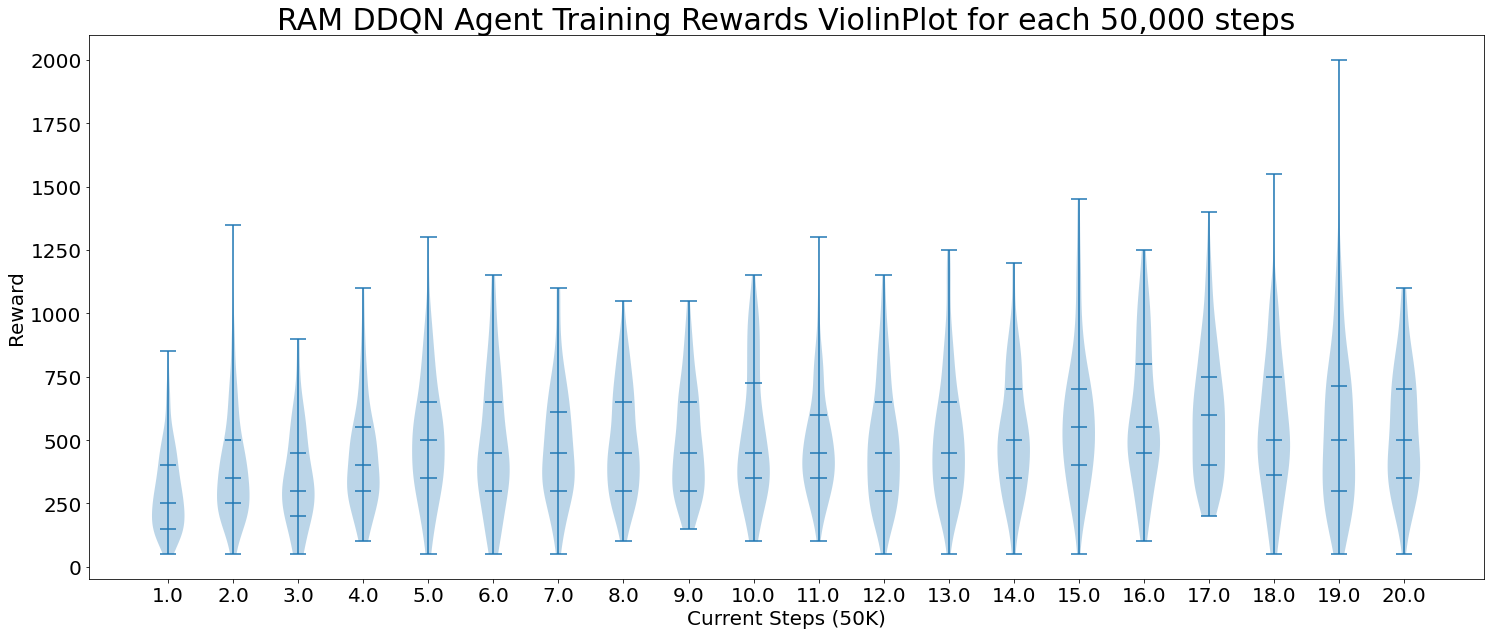

In [8]:
plot_violinplot_for_episodes(train_df, 
                             ['Reward'], 
                             ['DDQN-Image'], 
                             x_label='Current Steps (50K)', 
                             y_label='Reward', 
                             title='RAM DDQN Agent Training Rewards ViolinPlot for each 50,000 steps')

In [177]:
# Save the obtaine DDQN training data to a CSV file
train_df.to_csv('results/ddqn_ram_3.csv')

### Architecture

In [ ]:
# Create a HDF5 file with the trained online model
# with all the details necessary to reconstitute it. 
online_model = agent.online
online_model.save('ddqn_ram_3_online.h5') 

# Create a HDF5 file with the trained target model
# with all the details necessary to reconstitute it. 
target_model = agent.target
target_model.save('ddqn_ram_3_target.h5')  

In [8]:
# Print the RAM input DDQN (4 Dense layers apart 
# from the output layer) architecture summary
online_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               82048     
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dense_3 (Dense)             (None, 128)               16512     
                                                                 
 dense_4 (Dense)             (None, 9)                 1161      
                                                                 
Total params: 132,745
Trainable params: 132,745
Non-trainable params: 0
_________________________________________________________________


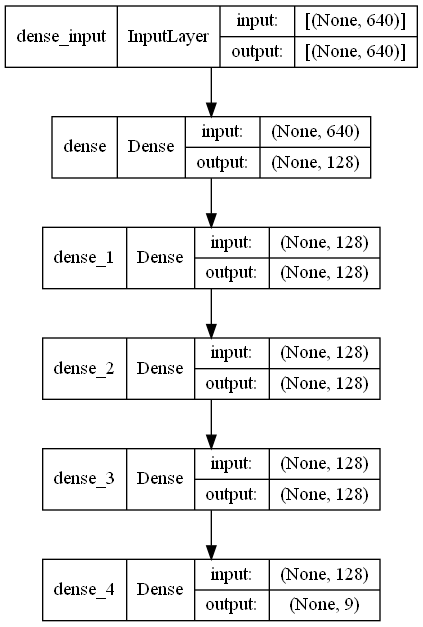

In [9]:
from tensorflow.keras.utils import plot_model

# Plot the RAM input DDQN and save it to a PNG file
plot_model(online_model, to_file="ram_ddqn_4.png", show_shapes=True)

## Task 2.4

For the comparison please refer to Notebook `Plots` which contains all performed experiments